# Anomaly detection project

- The goal of this project is to ....

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import os
import itertools

# DBSCAN imports
from sklearn.cluster import DBSCAN


# Visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

# .py imports
import env
import wrangle as w

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Data dictionary

| Column Name   | Description                                                  |
|---------------|--------------------------------------------------------------|
| time          | The timestamp when the website was viewed                     |
| viewed        | The specific webpage that was viewed                         |
| user_id       | The unique ID of the user who viewed the webpage              |
| ip            | The IP address of the user who viewed the webpage             |
| cohort_id     | The ID of the cohort associated with the user                 |
| name          | The name of the user                                          |
| start_date    | The start date of the cohort the user belongs to              |
| end_date      | The end date of the cohort the user belongs to                |
| program_id    | The ID of the program the user is enrolled in                 |


# Wrangle (acquire and prepare)
- The acquire and prepare stages are condensed into a function found in the wrangle.py file.
- The database was queried using MySQL and the resulting data was cleaned and prepared.
- After cleaning, the dataset contains 755,165 rows and 9 columns.
- Four columns ('cohort_id', 'slack', 'created_at', 'updated_at', 'deleted_at') were dropped from the dataset.
- The column names were renamed to improve clarity: 'path' was renamed to 'viewed', and 'id' was renamed to 'cohort_id'.
- Rows with '/' or 'toc' as the input in the 'viewed' column were removed.
- Web development and data science programs were identified based on the program ID, and the corresponding labels were assigned.
- All date-related columns were converted to the datetime data type, and the 'date' column was set as the index.
- The dataset had only one null value remaining, so the rows associated with it were dropped.

In [2]:
# Use wrangle file to get data and check it out
df = w.get_curr_log()
df.head()

,time,viewed,user_id,ip,cohort_id,name,start_date,end_date,program_id
date,,,,,,,,,
2018-01-26,09:56:24,javascript-i/conditionals,2,97.105.19.61,22,Teddy,2018-01-08,2018-05-17,web_dev
2018-01-26,09:56:41,javascript-i/loops,2,97.105.19.61,22,Teddy,2018-01-08,2018-05-17,web_dev
2018-01-26,09:56:46,javascript-i/conditionals,3,97.105.19.61,22,Teddy,2018-01-08,2018-05-17,web_dev
2018-01-26,09:56:48,javascript-i/functions,3,97.105.19.61,22,Teddy,2018-01-08,2018-05-17,web_dev
2018-01-26,09:56:59,javascript-i/loops,2,97.105.19.61,22,Teddy,2018-01-08,2018-05-17,web_dev


# Exploration
- In this phase, we answered 7 of the 8.
- The exploration phase will focus on answering those questions.

# 1. Which lesson appears to attract the most traffic consistently across cohorts (per program)?

In [3]:
# Calculate traffic count per lesson within each 'viewed' value
traffic_count_by_cohort = df.groupby(['viewed','cohort_id','program_id']).size().reset_index()
# Change column name 0 to hits
traffic_count_by_cohort = traffic_count_by_cohort.rename(columns={0 : 'hits'})
# Check it out
traffic_count_by_cohort.head()

,viewed,cohort_id,program_id,hits
0,%20https://github.com/RaulCPena,55,data_science,1
1,',28,web_dev,1
2,",%20https://github.com/RaulCPena",55,data_science,1
3,.git,24,web_dev,1
4,.gitignore,24,web_dev,1


- Find top hits for web dev

In [4]:
# Filter on web_dev
web_dev_traffic = traffic_count_by_cohort[traffic_count_by_cohort.program_id == 'web_dev'].sort_values(by='hits', ascending=False)

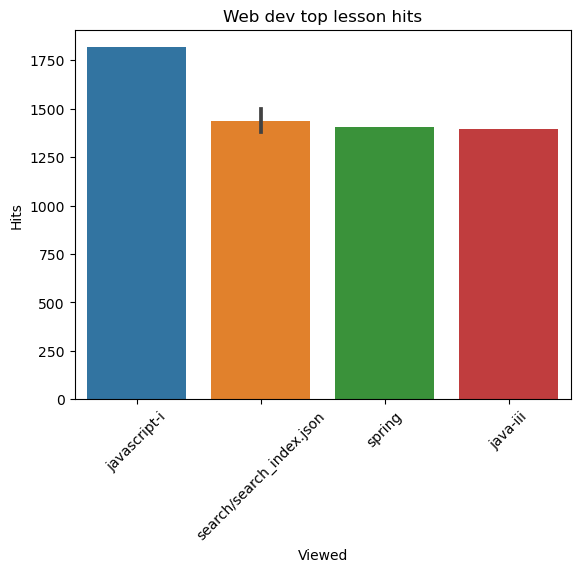

In [5]:
# Visualize web dev top hits
sns.barplot(data=web_dev_traffic.head(5), x='viewed', y= 'hits')
plt.title('Web dev top lesson hits')
plt.ylabel('Hits')
plt.xlabel('Viewed')
# Rotate the x-axis labels
plt.xticks(rotation=45)
plt.show()

- Find top hits for data science

In [6]:
# filter on data_science
data_science_traffic = traffic_count_by_cohort[traffic_count_by_cohort.program_id == 'data_science'].sort_values(by='hits', ascending=False).head(10)

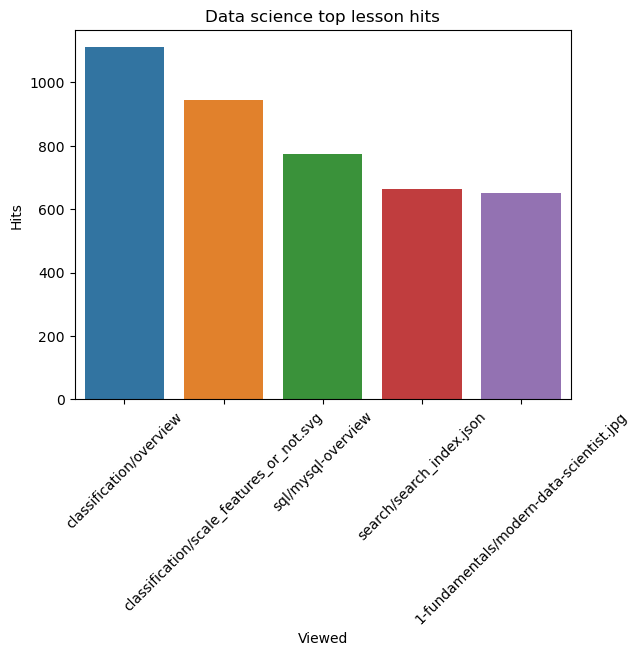

In [7]:
# Visualize data science top hits
sns.barplot(data=data_science_traffic.head(5), x='viewed', y='hits')

# Create Title
plt.title('Data science top lesson hits')

# Label Y axis
plt.ylabel('Hits')

# Label X axis
plt.xlabel('Viewed')

# Rotate the x-axis labels
plt.xticks(rotation=45)


# Display the plot
plt.show()

### Which lesson appears to attract the most traffic consistently across cohorts (per program)?
   - Javascript-i is the lesson with the most consistent traffic for web_dev with 1817 hits.
   - Classification/overview has the most consistent traffic for data_science with 1109 hits.

# 2. At some point in 2019, the ability for students and alumni to access both curriculums (web dev to ds, ds to web dev) should have been shut off. Do you see any evidence of that happening? Did it happen before?
- The below code identifies program likelihood based on commonalities between program specific courses.
- Two columns are created that identify students as 'likely in web dev', or 'likely in data science'
- Students that have courses in each column will be further investigated to determine whether they are viewing lessons outside of their assigned curriculums. 

In [8]:
# remove staff from df for this question
df = df[df['name'] != 'Staff']

In [9]:
#create a new column with the likelihood of the website viewed being considered web development based on keywords
df['likely_web_dev_course'] = np.where(df['viewed'].str.split('/').str[0].str.contains('javascript|java-|jquery|spring'), 'likely in web dev', 'not likely in web dev')
df.head(3)



,time,viewed,user_id,ip,cohort_id,name,start_date,end_date,program_id,likely_web_dev_course
date,,,,,,,,,,
2018-01-26,09:56:24,javascript-i/conditionals,2,97.105.19.61,22,Teddy,2018-01-08,2018-05-17,web_dev,likely in web dev
2018-01-26,09:56:41,javascript-i/loops,2,97.105.19.61,22,Teddy,2018-01-08,2018-05-17,web_dev,likely in web dev
2018-01-26,09:56:46,javascript-i/conditionals,3,97.105.19.61,22,Teddy,2018-01-08,2018-05-17,web_dev,likely in web dev


In [10]:
#create a new column with the likelihood of the website viewed being considered data science based on key words
df['likely_data_science_course'] = np.where(df['viewed'].str.split('/').str[0].str.contains('fundamentals|classification|regression|stats|anomaly|clustering|storytelling|data|1-|2-|3-|python|nlp|modeling'), 'likely in data science', 'not likely in data science')
df.head(3)



,time,viewed,user_id,ip,cohort_id,name,start_date,end_date,program_id,likely_web_dev_course,likely_data_science_course
date,,,,,,,,,,,
2018-01-26,09:56:24,javascript-i/conditionals,2,97.105.19.61,22,Teddy,2018-01-08,2018-05-17,web_dev,likely in web dev,not likely in data science
2018-01-26,09:56:41,javascript-i/loops,2,97.105.19.61,22,Teddy,2018-01-08,2018-05-17,web_dev,likely in web dev,not likely in data science
2018-01-26,09:56:46,javascript-i/conditionals,3,97.105.19.61,22,Teddy,2018-01-08,2018-05-17,web_dev,likely in web dev,not likely in data science


In [11]:
# Create temporary dataframe to identify users in both categorical groups
m_df = df.groupby('user_id').min()[['likely_web_dev_course','likely_data_science_course']]
m_df.head(3)



,likely_web_dev_course,likely_data_science_course
user_id,,
2,likely in web dev,not likely in data science
3,likely in web dev,not likely in data science
4,likely in web dev,not likely in data science


In [12]:

# create a mask to identify user_id that are contained in each column
mask = (m_df['likely_web_dev_course'] == 'likely in web dev') & (m_df['likely_data_science_course'] == 'likely in data science')
in_both_df = m_df.loc[mask]
in_both_df.head(3)

,likely_web_dev_course,likely_data_science_course
user_id,,
18,likely in web dev,likely in data science
20,likely in web dev,likely in data science
33,likely in web dev,likely in data science


### Investigate an example of a data science student viewing web development curriculum

In [13]:
#view websites viewed by specific user_id
specific_user_id = 476  

#create a variable to hold specific sites viewed by specific user identified
dates_opened = df.loc[df['user_id'] == specific_user_id, 'viewed']
dates_opened = dates_opened.drop_duplicates()

#output the dates and websites viewed by user id
print("Dates and Websites Viewed by User ID", specific_user_id)
for date, website in dates_opened.iteritems():
    print(date, website)

Dates and Websites Viewed by User ID 476
2019-08-20 1-fundamentals/1.1-intro-to-data-science
2019-08-20 1-fundamentals/modern-data-scientist.jpg
2019-08-20 1-fundamentals/AI-ML-DL-timeline.jpg
2019-08-21 1-fundamentals/1.2-data-science-pipeline
2019-08-21 1-fundamentals/DataToAction_v2.jpg
2019-08-21 1-fundamentals/1.3-pipeline-demo
2019-08-21 1-fundamentals/2.1-excel-overview
2019-08-21 6-regression/1-overview
2019-08-21 7-classification/2-intro-to-classification
2019-08-22 1-fundamentals/2.2-excel-functions
2019-08-22 1-fundamentals/2.3-visualization-with-excel
2019-08-22 1-fundamentals/2.4-more-excel-features
2019-08-22 1-fundamentals/project
2019-08-22 2-storytelling/1-overview
2019-08-22 2-storytelling/3-tableau
2019-08-22 2-storytelling/exercises
2019-08-22 3-vocabulary.md
2019-08-26 2-storytelling/2.1-understand
2019-08-27 2-storytelling/project
2019-08-27 2-storytelling/2.2-create
2019-08-27 2-storytelling/2.3-refine
2019-08-30 appendix/cli-git-overview
2019-08-30 appendix/cli/

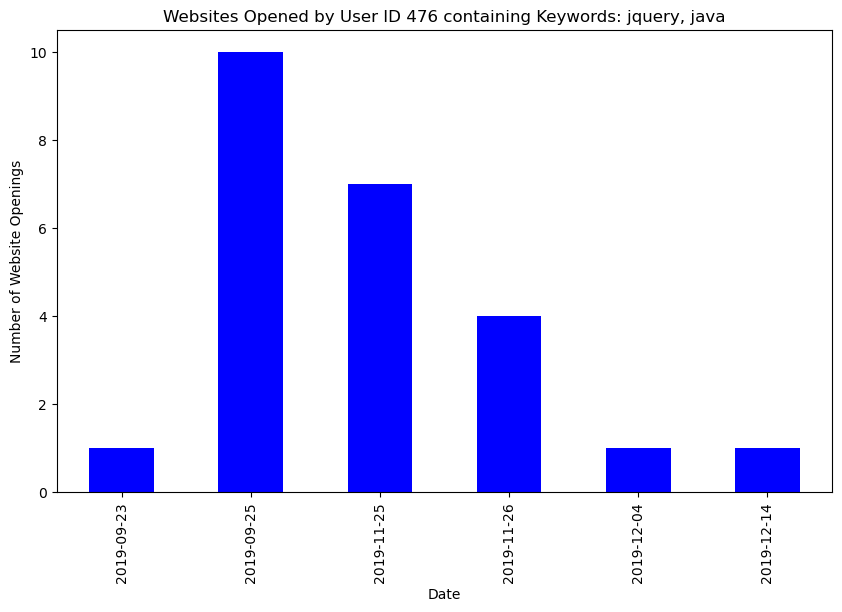

In [14]:
# Specify the user_id you want to analyze
specific_user_id = 476  

# Specify the keywords you want to search for
keywords = ['jquery', 'java']  

# Create a dataframe filtered by user_id, specified by input
filtered_df = df[df['user_id'] == specific_user_id]
filtered_dates = filtered_df[filtered_df['viewed'].str.contains('|'.join(keywords))].index

dates_counts = filtered_dates.value_counts().sort_index()

#plot dates that key words were visited
plt.figure(figsize=(10, 6))
dates_counts.plot(kind='bar', color='blue')
plt.xlabel('Date')
plt.ylabel('Number of Website Openings')
plt.title(f"Websites Opened by User ID {specific_user_id} containing Keywords: {', '.join(keywords)}")
plt.show()

### Explore example of a web dev student viewing data science curriculum

In [15]:
#view websites viewed by specific user_id
specific_user_id = 18

#create a variable to hold specific sites viewed by specific user identified
dates_opened = df.loc[df['user_id'] == specific_user_id, 'viewed']
dates_opened = dates_opened.drop_duplicates()

#output the dates and websites viewed by user id
print("Dates and Websites Viewed by User ID", specific_user_id)
for date, website in dates_opened.iteritems():
    print(date, website)

Dates and Websites Viewed by User ID 18
2018-01-26 javascript-i/functions
2018-01-26 javascript-i/conditionals
2018-01-26 javascript-i/introduction/primitive-types
2018-01-26 javascript-i/introduction/variables
2018-01-26 javascript-i/introduction/working-with-data-types-operators-and-variables
2018-01-26 javascript-i/introduction/operators
2018-01-26 javascript-i/loops
2018-01-29 html-css/forms
2018-01-29 mkdocs/search_index.json
2018-01-31 javascript-i/javascript-with-html
2018-01-31 javascript-i/arrays
2018-01-31 javascript-i/coffee-project
2018-01-31 javascript-i/google-maps-api
2018-01-31 javascript-i
2018-01-31 javascript-i/arrays/manipulating
2018-02-01 javascript-i/objects
2018-02-02 javascript-i/objects/math
2018-02-02 javascript-i/bom-and-dom/dom-events
2018-02-02 javascript-i/bom-and-dom
2018-02-02 javascript-i/bom-and-dom/bom
2018-02-02 javascript-i/bom-and-dom/dom
2018-02-02 examples/javascript/defuse-the-bom.html
2018-02-03 examples/javascript/dom-query-js.html
2018-02-05

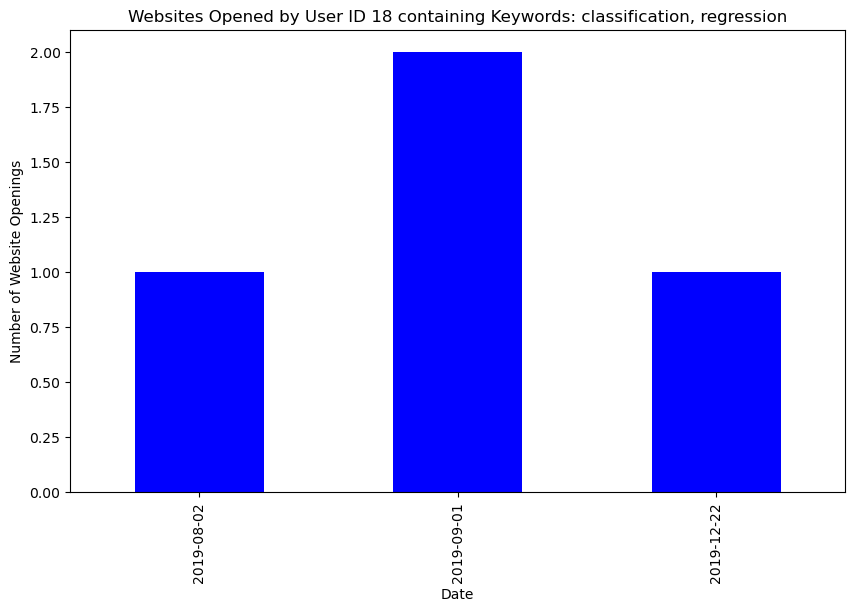

In [16]:
#Visualize
# Specify the user_id you want to analyze
specific_user_id = 18 

# Specify the keywords you want to search for
keywords = ['classification', 'regression']  

# Create a dataframe filtered by user_id, specified by input
filtered_df = df[df['user_id'] == specific_user_id]
filtered_dates = filtered_df[filtered_df['viewed'].str.contains('|'.join(keywords))].index

dates_counts = filtered_dates.value_counts().sort_index()

#plot dates that key words were visited
plt.figure(figsize=(10, 6))
dates_counts.plot(kind='bar', color='blue')
plt.xlabel('Date')
plt.ylabel('Number of Website Openings')
plt.title(f"Websites Opened by User ID {specific_user_id} containing Keywords: {', '.join(keywords)}")
plt.show()

At some point in 2019, the ability for students and alumni to access both curriculums (web dev to ds, ds to web dev) should have been shut off. Do you see any evidence of that happening? Did it happen before?

- I found that a few users from data science, user_id's #476, #472, #467, #268, and #33 had access to both curriculums from as early as 2018 with dual access ending 7 January 2020. I accomplished this by assigning lessons known to be specific to each discipline. For example, these identified users were accessing lessons involving jquery and java. 

- I found that two users from web development, user_id's #18, #20 had access to both curriculums. User #18, viewed data science courses three times in 2019. User #20 accessed the data science curriculum on 11 Nov 2020, this is the latest instance of any program viewing the other programs curriculum. I accomplished this by assigning lessons known to be specific to each discipline. For example, these identified users were accessing lessons involving regression analysis, classification, and data science fundamentals.

- All instances have stopped with duel access since early 2020 (with one user accessing on 11 Nov 2020), with the exception of staff.

# 3. Is there a cohort that referred to a lesson significantly while other cohorts seemed to gloss over?
- "Gloss over" defined by number of times visited not length of time of visit
- I want a count of how many times each cohort visited each page/piece of material

In [17]:
# Pulled the columns below from the original dataset because they are relevant to the question 
co_vi_da = df[['cohort_id', 'viewed', 'program_id']]

In [18]:
# Created a vist_count column to identify how many times each cohort visitied each page
count_df = co_vi_da.groupby(['cohort_id', 'viewed']).size().reset_index(name='visit_count')

In [19]:
# Selected javascript-i to isolate and get a visit_count per cohort
count_df[count_df.viewed == 'javascript-i'].sort_values(by='visit_count', ascending = True).head()

,cohort_id,viewed,visit_count
141,15,javascript-i,6
5047,34,javascript-i,10
285,16,javascript-i,23
576,18,javascript-i,69
9505,139,javascript-i,136


In [20]:
# Saved the count per cohort into visit_df for javascript-i
visit_df = count_df[count_df.viewed == 'javascript-i'].sort_values(by='visit_count', ascending = True)
visit_df.head()

,cohort_id,viewed,visit_count
141,15,javascript-i,6
5047,34,javascript-i,10
285,16,javascript-i,23
576,18,javascript-i,69
9505,139,javascript-i,136


### Is there a cohort that referred to A lesson significantly while other cohorts seemed to gloss over?

- In webdev cohort_id 15 visited javascript-i 130 less times than cohort 139. who visited javascript-i 136 times.

# 4. Are there students who, when active, hardly access the curriculum? If so, what information do you have about these students?
- Create a column for total number of visits per user
- Identify the users with the least amount of total visits


In [21]:
# Grabbing columns relavent to this question
df['visit_count'] = df.groupby(['time', 'user_id', 'ip', 'cohort_id'])['viewed'].transform('count')

In [22]:
# Creating variable with visit count per user id
user_visits = df.groupby('user_id')['visit_count'].sum().reset_index()

In [23]:
# Viewing visits by user in ascending order
user_visits.visit_count.sort_values(ascending = True)

668       1
99        1
54        2
58        2
646       2
       ... 
529    4555
245    5570
242    5647
357    6054
427    6356
Name: visit_count, Length: 784, dtype: int64

- There are several students who hardly visited the curriculum to include User_id #105, #700, and #520 who only accessed the curriculum for a combined total of 3 times.

# 5. Is there any suspicious activity, such as users/machines/etc accessing the curriculum who shouldn’t be? Does it appear that any web-scraping is happening? Are there any suspicious IP addresses?

- Look for suspicious counts of visit

In [24]:
# Group the data by  user ID, IP address, and cohort ID, and count the visits per all "groupby" members
df['visit_count'] = df.groupby(['time', 'user_id', 'ip', 'cohort_id'])['viewed'].transform('count')

- Create a columnn for avg visit count per cohort to help identify irregularities

In [25]:
# Average number times each cohort visits
average_visits_co = df.groupby('cohort_id')['visit_count'].mean().reset_index()
average_visits_co.rename(columns={'visit_count': 'average_visits_co'}, inplace=True)

# Merge the average visit count back into the original dataset
df = df.merge(average_visits_co, on='cohort_id', how='left')

- Create a columnn for max visit count per cohort to help identify irregularities

In [26]:
# Max number of times each cohort visited that page
max_visits_co = df.groupby(['cohort_id', 'viewed'])['visit_count'].max().reset_index()
max_visits_co.rename(columns={'visit_count': 'max_visits_co'}, inplace=True)

# Merge the maximum visit count back into the original dataset
df = df.merge(max_visits_co, on=['cohort_id', 'viewed'], how='left')

- Create a columnn for max visit count per user to help identify irregularities

In [27]:
# Max number of times each user visited that page
max_visits_user = df.groupby(['user_id', 'viewed'])['visit_count'].max().reset_index()
max_visits_user.rename(columns={'visit_count': 'max_visits_user'}, inplace=True)

# Merge the maximum visit count back into the original dataset
df = df.merge(max_visits_user, on=['user_id', 'viewed'], how='left')

- Create a columnn for avg visit count per user to help identify irregularities

In [28]:
# Show average number of times that item was visited by that cohort
avg_visits_user = df.groupby('user_id')['visit_count'].mean().reset_index()
avg_visits_user.rename(columns={'visit_count': 'avg_visits_user'}, inplace=True)

# Merge the average visit count back into the original dataset
df = df.merge(avg_visits_user, on='user_id', how='left')

- It would be slightly abnormal if a specific user_id accessed the same material more than once within the same timestamp/second


In [29]:
# Filtered for similar visits on duplicated timestamps 
filtered_df = df[df['visit_count']> 1]
pd.DataFrame(filtered_df).head(3)

,time,viewed,user_id,ip,cohort_id,name,start_date,end_date,program_id,likely_web_dev_course,likely_data_science_course,visit_count,average_visits_co,max_visits_co,max_visits_user,avg_visits_user
48,10:41:22,javascript-i/functions,19,97.105.19.61,22,Teddy,2018-01-08,2018-05-17,web_dev,likely in web dev,not likely in data science,2,1.068241,2,2,1.134574
49,10:41:22,javascript-i/conditionals,19,97.105.19.61,22,Teddy,2018-01-08,2018-05-17,web_dev,likely in web dev,not likely in data science,2,1.068241,4,2,1.134574
120,11:47:38,javascript-i/javascript-with-html,5,97.105.19.61,22,Teddy,2018-01-08,2018-05-17,web_dev,likely in web dev,not likely in data science,2,1.068241,3,2,1.067039


In [30]:
# Sorted by visit_count in descending order
df = filtered_df.sort_values('visit_count', ascending=False)
df.head(5)

,time,viewed,user_id,ip,cohort_id,name,start_date,end_date,program_id,likely_web_dev_course,likely_data_science_course,visit_count,average_visits_co,max_visits_co,max_visits_user,avg_visits_user
164116,22:52:09,mysql/tables,341,204.44.112.76,29,Zion,2019-01-22,2019-06-04,web_dev,not likely in web dev,not likely in data science,30,1.168863,30,30,3.717577
164075,22:52:07,javascript-i/bom-and-dom,341,204.44.112.76,29,Zion,2019-01-22,2019-06-04,web_dev,likely in web dev,not likely in data science,30,1.168863,30,30,3.717577
164087,22:52:07,jquery/essential-methods/attributes-and-css,341,204.44.112.76,29,Zion,2019-01-22,2019-06-04,web_dev,likely in web dev,not likely in data science,30,1.168863,30,30,3.717577
164086,22:52:07,jquery/ajax,341,204.44.112.76,29,Zion,2019-01-22,2019-06-04,web_dev,likely in web dev,not likely in data science,30,1.168863,30,30,3.717577
164085,22:52:07,jquery/essential-methods/traversing,341,204.44.112.76,29,Zion,2019-01-22,2019-06-04,web_dev,likely in web dev,not likely in data science,30,1.168863,30,30,3.717577


### Is there any suspicious activity, such as users/machines/etc accessing the curriculum who shouldn’t be? Does it appear that any web-scraping is happening? Are there any suspicious IP addresses?
- Several "users" accessed material a suspicious amount of times within a second for example user_id 341 made a total of 150 visits across 5 different pieces of material and 2 different programs. Visiting 'javascript-i/arrays' and 'javascript-i/loops' 30x each in one second for a total of 60x, and 'mysql/relationships/sub-queries,' 'spring/fundamentals/controllers,' and 'spring/fundamentals/views' 30x each for a total of 90 visits within the same second. This was done while the average number of visits per cohort for was appx 1.17 for each piece of material.

# Takeaways and Conclusions:

# Recommendations: